In [1]:
!pip install kaggle

In [4]:
from google.colab import files
files.upload()

KeyboardInterrupt: ignored

In [0]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle

#change permission
!chmod 600 ~/

In [5]:
!kaggle datasets download -d techsash/waste-classification-data

waste-classification-data.zip: Skipping, found more recently modified local copy (use --force to force download)


In [5]:
from zipfile import ZipFile
file_name = "waste-classification-data.zip"

with ZipFile(file_name, 'r') as zip:
  zip.extractall()
  print('Done')

Done


In [0]:
def parse_metadata(file_path):
  path_parts = file_path.split('/')
  file_name = path_parts[-1]
  label = path_parts[-2]
  purpose = path_parts[-3]
  #print(f'file_name:{file_name}')
  #print(f'label:{label}')
  #print(f'purpose:{purpose}')
  return (file_path, file_name, label, purpose)

In [0]:
import pandas as pd
import numpy as np

In [25]:
from pathlib import Path
path = Path('./DATASET')
data = [parse_metadata(file_path.as_posix()) for file_path in path.glob('**/*.jpg')]
df = pd.DataFrame(data, columns =['file_path', 'file_name', 'label', 'purpose'])
image_count = len(list(path.glob('**/*.jpg')))
print(f'image_count:{image_count}')

BATCH_SIZE = 32
IMG_HEIGHT = 224
IMG_WIDTH = 224
STEPS_PER_EPOCH = np.ceil(image_count/BATCH_SIZE)

image_count:25077


In [6]:
df.describe()

,file_path,file_name,label,purpose
count,25077,25077,25077,25077
unique,25077,25077,2,2
top,DATASET/TRAIN/O/O_3349.jpg,O_1882.jpg,O,TRAIN
freq,1,1,13966,22564


In [7]:
from __future__ import absolute_import, division, print_function, unicode_literals

try:
  # %tensorflow_version only exists in Colab.
  !pip install tf-nightly
except Exception:
  pass
import tensorflow as tf
print(tf.__version__)

2.1.0-dev20191022


In [0]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [0]:
import IPython.display as display
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

In [0]:
CLASS_NAMES = df['label'].unique()

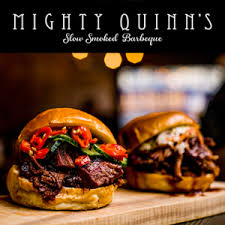

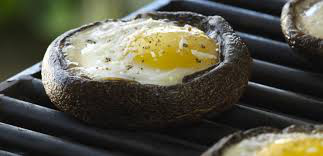

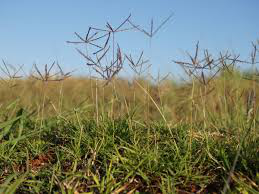

[None, None, None]

In [11]:
mask = df['label'] == 'O'
[display.display(Image.open(file_path)) for file_path in df[mask]['file_path'].head(3)]

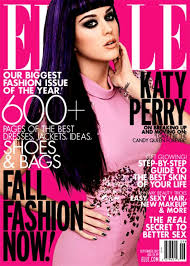

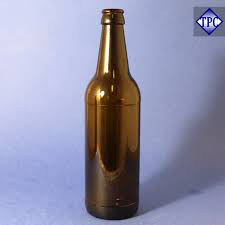

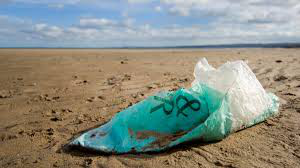

[None, None, None]

In [12]:
mask = df['label'] == 'R'
[display.display(Image.open(file_path)) for file_path in df[mask]['file_path'].head(3)]

In [0]:
def show_batch(image_batch, label_batch):
  plt.figure(figsize=(10,10))
  for n in range(25):
      ax = plt.subplot(5,5,n+1)
      plt.imshow(image_batch[n])
      plt.title(CLASS_NAMES[label_batch[n]==1][0].title())
      plt.axis('off')

In [0]:
def decode_img(img):
  # convert the compressed string to a 3D uint8 tensor
  img = tf.image.decode_jpeg(img, channels=3)
  # Use `convert_image_dtype` to convert to floats in the [0,1] range.
  img = tf.image.convert_image_dtype(img, tf.float32)
  # resize the image to the desired size.
  return tf.image.resize(img, [IMG_WIDTH, IMG_HEIGHT])

def get_label(file_path):
  path_parts = file_path.split('/')
  file_name = path_parts[-1]
  label = path_parts[-2]
  purpose = path_parts[-3]
  #print(f'file_name:{file_name}')
  #print(f'label:{label}')
  #print(f'purpose:{purpose}')
  return label

def process_path(file_path):
  label = get_label(file_path)
  # load the raw data from the file as a string
  img = tf.io.read_file(file_path)
  img = decode_img(img)
  return img, label

In [0]:
list_ds = tf.data.Dataset.list_files(str(path/'*/*/*.jpg'))

In [15]:
for f in list_ds.take(5):
  print(f.numpy())

b'DATASET/TRAIN/O/O_6593.jpg'
b'DATASET/TRAIN/R/R_7875.jpg'
b'DATASET/TRAIN/R/R_6423.jpg'
b'DATASET/TRAIN/O/O_2017.jpg'
b'DATASET/TRAIN/R/R_7911.jpg'


In [0]:
def get_label(file_path):
  # convert the path to a list of path components
  parts = tf.strings.split(file_path, '/')
  # The second to last is the class-directory
  return parts[-2] == CLASS_NAMES

In [0]:
def decode_img(img):
  # convert the compressed string to a 3D uint8 tensor
  img = tf.image.decode_jpeg(img, channels=3)
  # Use `convert_image_dtype` to convert to floats in the [0,1] range.
  img = tf.image.convert_image_dtype(img, tf.float32)
  # resize the image to the desired size.
  IMG_HEIGHT = 224
  IMG_WIDTH = 224
  return tf.image.resize(img, [IMG_WIDTH, IMG_HEIGHT])

In [0]:
def process_path(file_path):
  label = get_label(file_path)
  # load the raw data from the file as a string
  img = tf.io.read_file(file_path)
  img = decode_img(img)
  return img, label

In [0]:
# Set `num_parallel_calls` so multiple images are loaded/processed in parallel.
labeled_ds = list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [22]:
for image, label in labeled_ds.take(1):
  print("Image shape: ", image.numpy().shape)
  print("Label: ", label.numpy())

Image shape:  (224, 224, 3)
Label:  [ True False]


In [0]:
def prepare_for_training(ds, cache=True, shuffle_buffer_size=1000):
  # This is a small dataset, only load it once, and keep it in memory.
  # use `.cache(filename)` to cache preprocessing work for datasets that don't
  # fit in memory.
  if cache:
    if isinstance(cache, str):
      ds = ds.cache(cache)
    else:
      ds = ds.cache()

  ds = ds.shuffle(buffer_size=shuffle_buffer_size)

  # Repeat forever
  ds = ds.repeat()

  ds = ds.batch(BATCH_SIZE)

  # `prefetch` lets the dataset fetch batches in the background while the model
  # is training.
  ds = ds.prefetch(buffer_size=AUTOTUNE)

  return ds

In [0]:
train_ds = prepare_for_training(labeled_ds)

image_batch, label_batch = next(iter(train_ds))

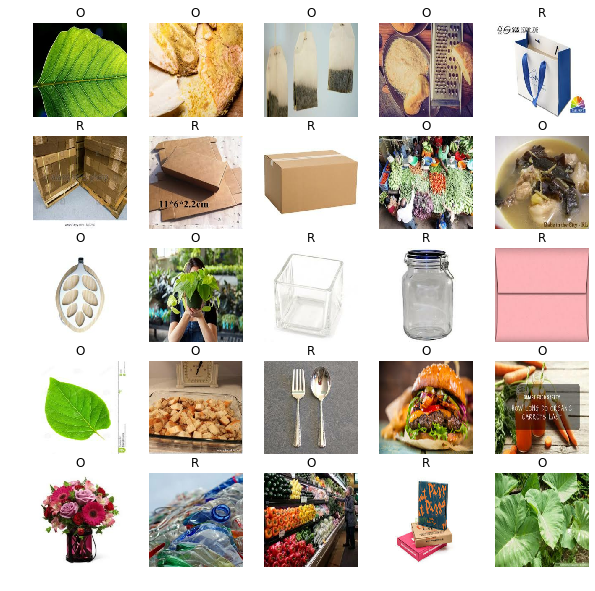

In [33]:
show_batch(image_batch.numpy(), label_batch.numpy())

In [0]:
import time
default_timeit_steps = 1000

def timeit(ds, steps=default_timeit_steps):
  start = time.time()
  it = iter(ds)
  for i in range(steps):
    batch = next(it)
    if i%10 == 0:
      print('.',end='')
  print()
  end = time.time()

  duration = end-start
  print("{} batches: {} s".format(steps, duration))
  print("{:0.5f} Images/s".format(BATCH_SIZE*steps/duration))

In [1]:
filecache_ds = prepare_for_training(labeled_ds, cache="./flowers.tfcache")
timeit(filecache_ds)

NameError: ignored